## Author Explorer: Let's Make Some Paper Lists!

Let's try to produce a list of interesting AI papers from a set of authors.

### Step 1: Examine Input Data

To do so we'll use some data that's not yet available via Semantic Scholar's public API (we're working on that). Let's take a look at the authors we have in that output. It's a list we put together by hand, and I'm sure misses a few folks. But never the less feels like an ok list for exploring.

In [1]:
import json
import pandas as pd

from IPython.display import HTML, display
from pretty_html_table import build_table

def s2_url(path: str) -> str:
    url = f"https://semanticscholar.org{path}"
    return url

def href(url: str) -> str:
    return f"<a href={url}>{url}</a>"

author_citations = json.load(open("author_citations.json", "r"))

authors = []
for id, a in author_citations.items():
    authors.append({ "id": id, "name": a["name"], "url": href(s2_url(f"/author/{id}")) })
    
adf = pd.DataFrame(authors)
display(HTML(build_table(adf, 'green_dark', escape=False)))


id,name,url
1780531,Dan Weld,https://semanticscholar.org/author/1780531
2684226,Ani Kembhavi,https://semanticscholar.org/author/2684226
1699545,Yejin Choi,https://semanticscholar.org/author/1699545
48323507,Peter Clark,https://semanticscholar.org/author/48323507
144365875,Noah Smith,https://semanticscholar.org/author/144365875
2548384,Hannaneh Hajishirzi,https://semanticscholar.org/author/2548384
1701686,Ilya Sutskever,https://semanticscholar.org/author/1701686
1695689,Geoffrey E. Hinton,https://semanticscholar.org/author/1695689
1741101,Oren Etzioni,https://semanticscholar.org/author/1741101
48004138,Li Fei-Fei,https://semanticscholar.org/author/48004138


Naturally we have a lot of folks from AI2. We threw in a few Turing award winners too. And of course, Ilya Sutksever, as that's what inspired this effort to begin with!

Before we move on let's talk quickly about the data that's in `author_citations.json`. That file contains a map of author IDs to the top 25 papers cited by that author. To find those papers we sort by the unique citation count, and take the first 25. We could probably take into consideration S2's highly influential citation classifier but didn't at this point. Maybe we'll do that in the future.

The file could thus be described by the type `map[str, AuthorCitations]`, where each `AuthorCitations` instance is defined as such:

```
class AuthorCitations:
    # The author's anme
    name: str
    # The 25 most cited papers by that author.
    papers: list[CitedPaper]
```

...and a `CitedPaper` looks like so:

```
class CitedPaper:
    # A SHA derived from the paper, that acts as a public, unique identifier. We could talk a lot about
    # how this is generated but won't here.
    paper_sha: str
    # An internal identifier for the paper. You can ignore this.
    corpus_paper_id: int
    # The paper's title.
    title: str
    # The unique number of times the paper was cited by the author.
    n_citations: int
    # The total number of times the paper was cited across the whole corpus, or the "global citations".
    g_citations: int
    # The year the paper was published
    year: int
    # True if the cited paper was also written by the author
    self_cited: bool
```

Let's dump out some data to confirm the shape:


In [2]:
from copy import deepcopy

first_id = list(author_citations.keys())[0]

# Make a copy, to not mutate the original
first_author = deepcopy(author_citations[first_id])
first_author["papers"] = first_author["papers"][0:2]

print(json.dumps({ first_id: first_author }, indent=2))

{
  "1780531": {
    "name": "Dan Weld",
    "papers": [
      {
        "paper_sha": "6e1bd5758be5495141d56de31c28d57f55c56f3e",
        "corpus_paper_id": 5329862,
        "title": "UCPOP: A Sound, Complete, Partial Order Planner for ADL",
        "n_citations": 33,
        "g_citations": 930,
        "year": 1992,
        "self_cited": true
      },
      {
        "paper_sha": "02cc8ee37b11e7bd96a3bc1095a8bee6b154bcf4",
        "corpus_paper_id": 2584923,
        "title": "Systematic Nonlinear Planning",
        "n_citations": 29,
        "g_citations": 731,
        "year": 1991,
        "self_cited": false
      }
    ]
  }
}


### Step 2: Enrich the Data using Semantic Scholar's Public API

Next we'll go through the papers they cite the most and mix in some extra information from Semantic Scholar's API that we'll use later.

We sort each author's list of citations by the `n_citations` field. This is the number of unique papers by the author that cited the paper.

In [3]:
from typing import Optional, List, Tuple
from tqdm import tqdm
from os import path

import requests

# To avoid rate limits, create a file called key.txt with your Semantic Scholar API key.
api_key = None
if path.isfile("key.txt"):
    api_key = open("key.txt").read().strip()
if api_key is not None:
    assert(api_key != "")
    print("INFO: your Semantic Scholar API key will be used.")

def get_extra_fields(sha: str) -> Tuple[str, List[float]]:
    """
    Fetch the TLDR and SPECTRE embedding. These might not exist, so we handle
    failure gracefully.
    
    The first value is the TLDR. The second is the SPECTRE embedding.
    """    
    headers = None
    if api_key is not None:
        headers = { "x-api-key": api_key }
    resp = requests.get(
        f"https://api.semanticscholar.org/graph/v1/paper/{sha}?fields=tldr,embedding",
        headers=headers,
    )
    if resp.status_code != 200:
        return ["", []]
    payload = resp.json()
    tldr = payload.get("tldr")
    embed = payload.get("embedding")
    return (
        tldr["text"] if tldr is not None else "",
        embed["vector"] if embed is not None else []
    )

# We'll keep them in a list to use later
papers = []

for id, a in tqdm(author_citations.items()):
    most_cited = sorted(a["papers"], key=lambda p : p["n_citations"], reverse=True)    
    for p in most_cited[:10]:
        tldr, embed = get_extra_fields(p["paper_sha"])
        paper = {
            "id": id,
            "sha": p["paper_sha"],
            "author_id": id,
            "author_name": a["name"],
            "title": p["title"],
            "n_citations": p["n_citations"],
            "g_citations": p["g_citations"],
            "self_citation": p["self_cited"],
            "year": p["year"],
            "url": s2_url(f"/paper/{p['paper_sha']}"),
            "tldr": tldr,
            "embedding": embed,
        }
        papers.append(paper)        
        
# We don't output much, so that this cell can be cached (it's slow).
print(len(papers))


INFO: your Semantic Scholar API key will be used.


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it]

160


160 papers are too many to display in a notebook. Clearly we need to build this into S2 instead :)

In the meantime we'll take a look at single author's list, just to see what things look like. Given this whole exercise spawned via curiosity about Ilya Sutskever's list, let's take a look at that list first.

In [4]:
def paper_meta_html(p) -> str:
    return f"""
        <p style="margin: 5px 0;">
            {p["year"]} • Unique Citations: {p["n_citations"]} • {"Self Citation" if p["self_citation"] else "Not Self Citation"}
        </p>
    """

def paper_html(p, meta) -> str:
    return f"""
        <div style="margin: 15px 0;">
            <h4 style="margin: 0; font-weight: bold; font-size: 16px">{p["title"]}</h4>
            {meta(p)}
            <div style="max-width: 70ch; margin: 5px 0;">
                <span style="font-size: 12px; background: #eee; border-radius: 2px; padding: 2px 4px; line-height: 1; display: inline-block">
                    TLDR
                </span>
                <span style="font-size: 12px;">{p["tldr"]}</span>
            </div>
            <div style="font-size: 12px">
                <a href="{p["url"]}">
                    {p["url"]}
                </a>
            </div>
        </div>
    """

ilyas = [ p for p in papers if p["author_id"] == "1701686" ]
ilyas_html = "\n".join([ paper_html(p, paper_meta_html) for p in ilyas ])
display(HTML(f"""
    <div style='padding: 15px 0;'>
        <h3 style='border-bottom: 1px solid #eee; padding-bottom: 10px;'>Ilya's Most Cited papers</h3>
        {ilyas_html}
    </div>
"""))


It's fun to look at what's there. I wonder how many of these were in the list that Ilya delivered to Carmack.

### Step 3: Find the Intersection

A single author's list is, by nature, a limited view. Let's use the data from all of the authors in the input data to build a list that *might* be more complete.

To do so we'll start by finding the papers that appear on more than one author's list of top citations. We'll rank the results by the number of unique authors who cite them, thereby biasing towards papers that are cited by more distinct authors (in our input data).


In [5]:
def common_paper_meta_html(p) -> str:
    cited_by = []
    for a in p["cited_by"]:
        cited_by.append(f"{a['author_name']} ({a['n_citations']})")
    cited_by_list = ", ".join(cited_by)
    return f"""
        <div style="margin: 5px 0;">
            {p["year"]}
        </div>
        <div style="margin: 5px 0;">
            <em>Cited By: {cited_by_list}</em>
        </div>        
    """

common = []
for sha, group in pd.DataFrame(papers).groupby("sha"):
    if len(group) == 1:
        continue
    by_author_id = {}
    paper = None
    for _, p in group.iterrows():
        paper = p
        if p["author_id"] not in by_author_id:
            by_author_id[p["author_id"]] = { "author_id": p["author_id"], "author_name": p["author_name"], "n_citations": 0 }
        by_author_id[p["author_id"]]["n_citations"] += p["n_citations"]
    cited_by = sorted(by_author_id.values(), key=lambda a: a["n_citations"], reverse=True)
    paper["cited_by"] = cited_by
    common.append(paper)    
    
common.sort(key=lambda p : len(p["cited_by"]), reverse=True)
list_html = "\n".join([ paper_html(p, common_paper_meta_html) for p in common ])
display(HTML(f"""
    <div style='padding: 15px 0;'>
        <h3 style='border-bottom: 1px solid #eee; padding-bottom: 10px;'>Citation Intersection</h3>
        {list_html}
    </div>
"""))

This list looks pretty interesting. There's some really important work captured there. There's also some older papers. Neat!

It'd be interesting next to assess how many of these were cited by Ilya, as a proxy for how comprehensive his list is. Let's figure that out:


In [6]:
total = len(common)

authors = {}
for p in common:
    for c in p["cited_by"]:
        if c["author_id"] not in authors:
            authors[c["author_id"]] = { "author_id": c["author_id"], "author_name": c["author_name"] }

overlap = []
for a in authors.values():
    count = len([p for p in common if a["author_id"] in [c["author_id"] for c in p["cited_by"]]])
    overlap.append({ "name": a["author_name"], "count": count, "percent": f"{count/total:.0%}" })
    
overlap.sort(key=lambda o : o["count"], reverse=True)

display(HTML(build_table(pd.DataFrame(overlap), 'blue_dark', escape=False)))


name,count,percent
R. Socher,8,33%
Hannaneh Hajishirzi,8,33%
Ilya Sutskever,8,33%
Yejin Choi,7,29%
Yoshua Bengio,6,25%
Li Fei-Fei,5,21%
Noah Smith,5,21%
Ani Kembhavi,4,17%
A. Karpathy,4,17%
Peter Clark,4,17%


Interesting. This does suggest Ilya's most cited papers overlap a fair amount with the other researchers in our list.

### Step 4: Similarity Analysis

We thought it'd be fun to go a step further and use the [SPECTER embeddings](https://github.com/allenai/specter) to visualize the lists of each of these authors. This in theory gives us an idea of how "similar" the things are that they're citing.

Let's do that next. First we'll do some data processing.

In [7]:
from sklearn.manifold import TSNE

import plotly.express as px
import numpy as np

# Produce a map of unique papers by ID, including the names of authors who cite them.
unique_papers = dict()
for p in tqdm(papers):
    if p["sha"] not in unique_papers:
        pc = deepcopy(p)
        pc["names"] = [p["author_name"]]
        unique_papers[p["sha"]] = pc        
    else:
        unique_papers[p["sha"]]["names"] += [p["author_name"]]

# Next prepare a reverse index of author names to the indices (the paper SHA and index).
author_paper_idx = dict()
for i, p in tqdm(enumerate(unique_papers)):
    for aname in unique_papers[p]["names"]:
        if aname not in author_paper_idx:
            author_paper_idx[aname] = []
        author_paper_idx[aname].append((unique_papers[p]["sha"], i))
        
# Produce an array of the unique paper embeddings.
unique_paper_embs = np.array([unique_papers[p]["embedding"] for p in unique_papers])

# Use TSNE to reduce to 2D space:
# https://lvdmaaten.github.io/tsne/
reduced_embs = TSNE(
    n_components=2,
    perplexity=10,
    init="pca",
    n_iter=400,
    early_exaggeration=20,
    random_state=0,
).fit_transform(unique_paper_embs)    

# Prepare a dataframe for plotting things.
reduced_comps = []
for aname, ids in author_paper_idx.items():
    for idx in ids:
        reduced_comps.append({"Dim 1": reduced_embs[idx[1]][0], "Dim 2": reduced_embs[idx[1]][1], 
                              "Title": unique_papers[idx[0]]["title"], "Citations": unique_papers[idx[0]]["n_citations"],
                              "Cited By": aname})
reduced_df = pd.DataFrame(reduced_comps)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 8533.36it/s]
110it [00:00, 1360983.60it/s]


Now that we've processed the data into the shape we need, let's go ahead and prepare a few graphs.

### Naive Author Clustering

First let's cluster authors by their top citations. The size of each marker is dictated by the number of unique citations for that author.


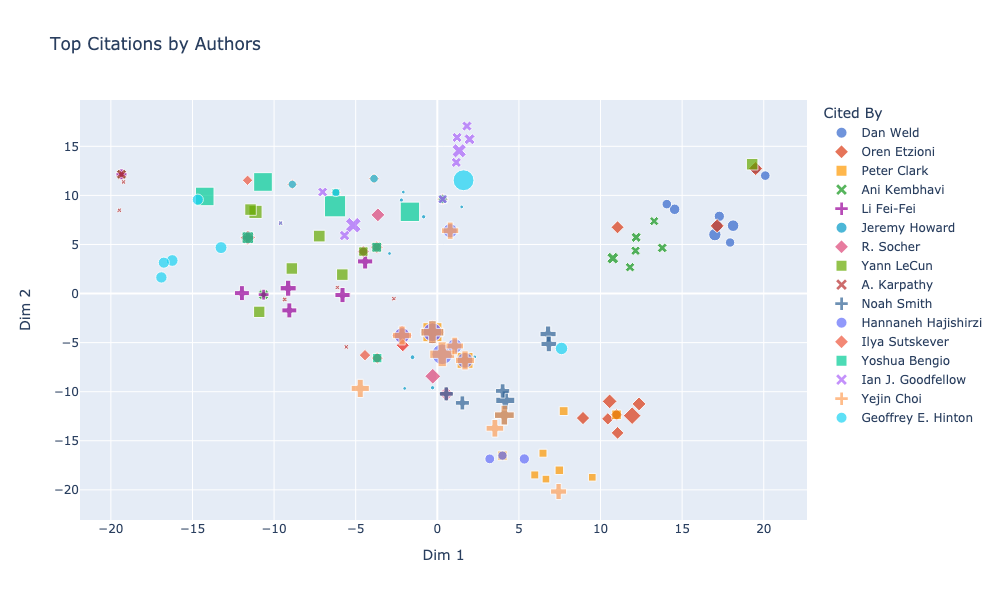

In [8]:
import plotly.io as pio

# This is commented out to support rendering w/ interactivity when ran via Binder. If you're going to publish
# a new version to GitHub uncomment these lines before running things.
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 600
pio.renderers.default = "png"

fig=px.scatter(reduced_df, x="Dim 1", y="Dim 2", color="Cited By", symbol="Cited By", title="Top Citations by Authors",
               hover_data=["Title"], size="Citations", size_max=15, 
               color_discrete_sequence= px.colors.qualitative.G10+px.colors.qualitative.Plotly)
fig.show()

In the top left we have Turing award winners like Yann LeCun, Yoshua Bengio and Geoffrey Hinton.

In the middle we have Yejin, Hannaneh and Noah. Three leaders and significant contributors to AI2, we're not to surprised to see them cited similar work.

Interestingly in the top right we have Dan Weld and Ani Kembhavi. This appears to be due to some focus on intelligent agents. Dan will have to tell us more about his work here. Ani's is pretty clear with respect to THOR and the work he's been a part of on PRIOR.

In the bottom right we see Oren and Peter. Hey, they'r eboth CEOs, maybe that explains that. Kidding, their hard work and focus on Aristo and related domains like information extraction explains that.

All in all no huge surprises, but fun to visualize never the less.

## Author Clustering via Centroids

Next we'll graph authors by the mean embeddings of their citations. This acts to reduce the numbers the points we're visualization so that it's easier to examine the space occupied by a single author.




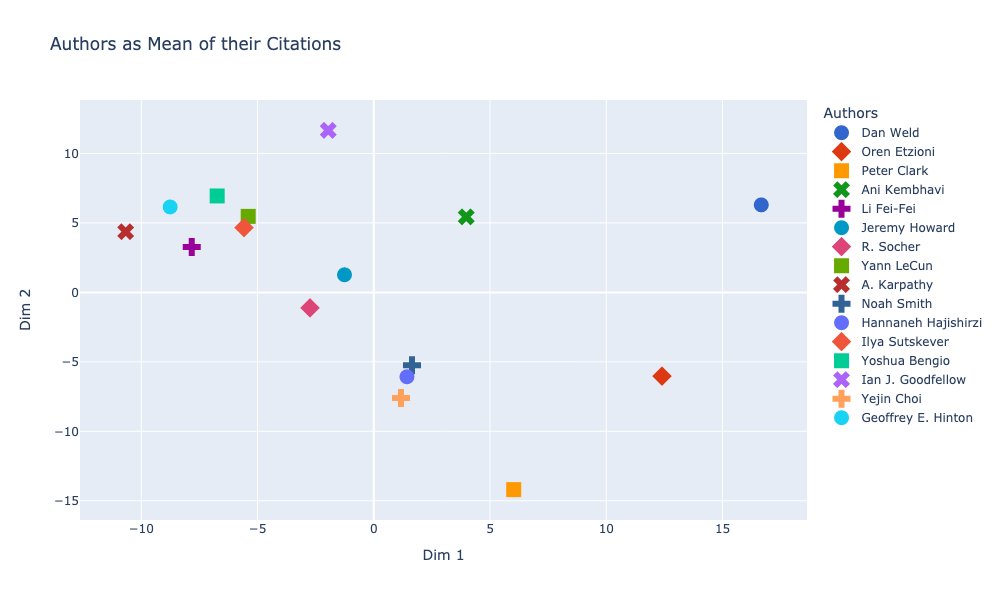

In [9]:
mean_reduced_embs = []
authors = list(author_paper_idx.keys())
for aname in authors:
    x=reduced_df[reduced_df["Cited By"]==aname]["Dim 1"].mean()
    y=reduced_df[reduced_df["Cited By"]==aname]["Dim 2"].mean()
    mean_reduced_embs.append((x,y))
    
fig=px.scatter(x=[c[0] for c in mean_reduced_embs], y=[c[1] for c in mean_reduced_embs], 
               labels= {"x": "Dim 1", "y": "Dim 2", "color": "Authors", "symbol": "Authors"},
               color=authors, symbol=authors, title="Authors as Mean of their Citations",
              color_discrete_sequence= px.colors.qualitative.G10+px.colors.qualitative.Plotly)
fig.update_traces(marker={'size': 15})
fig.show()

Again we see our three Turing winners in close proximity. We see other prominent reserachers like Fei-Fei Li and Karpathy close to those folks.

We see Dan and Oren a bit further from this, probably because they're working less on deep learning.

And finally, again we have Yejin, Noah and Hannaneh in the center. Their work is closer to deep learning, but also clearly is charting new (and important) territory.

### Paper Clustering

As a final exercise we'll cluster papers instead of authors. The size of each marker is based on the total number of citations for the paper.

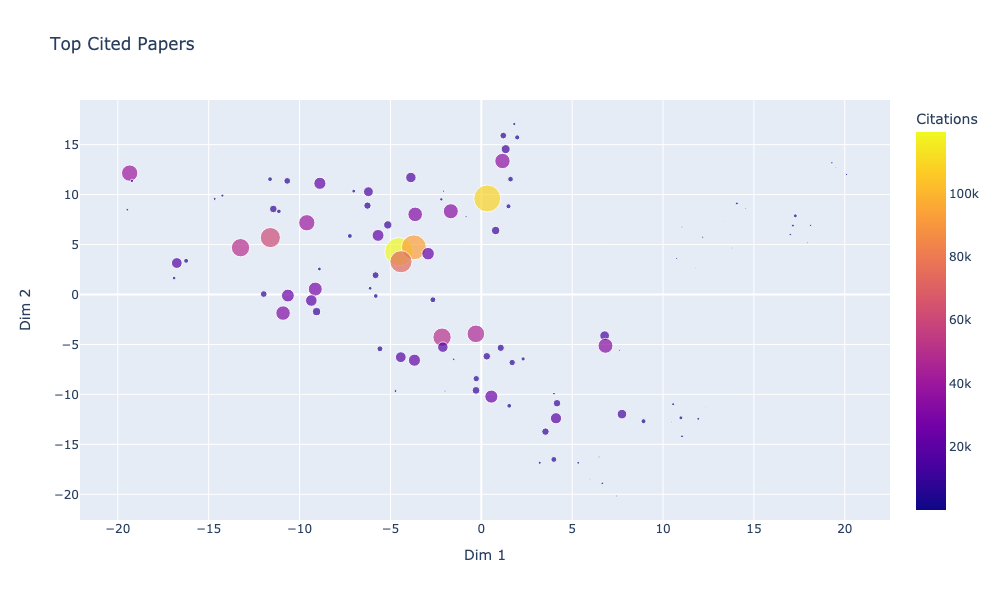

In [10]:
cited_papers_df = pd.DataFrame([{"Title": unique_papers[p]["title"], "Year": unique_papers[p]["year"], 
                                 "Citations": unique_papers[p]["g_citations"], 
                                 "Dim 1": reduced_embs[i, 0], "Dim 2": reduced_embs[i, 1]} 
                                for i, p in enumerate(unique_papers)])

fig=px.scatter(cited_papers_df, x="Dim 1", y="Dim 2", color="Citations", title="Top Cited Papers",
               hover_data=["Title", "Year"], size="Citations")
fig.show()

In the graph's origin we see BERT. Not too surprising. The original transformers paper is also there as a close neighbor. Again, no surprise to us.

The biggest number of citations goes to the "Adam" paper which is obviously used throughout deep learning for. And ImageNet in the top left and also highly cited -- which makes sense as it's a seminal CV paper.

An interesting point is that papers are roughly clustered based on the year they were published. We're not sure exactly what this means. Maybe that there's some periodic nature to the influence a paper has, or something else. Let us know if you find out!

Again no major discoveries or anything -- but interesting to look at the data this way!


### That's all (for now)!

This was fun. We hope you enjoyed it too. We also think the list of papers probably includes a few that are worth reading if you're looking to learn more about AI. 

If you find this type of thing interesting, definitely look into [Semantic Scholar's Academic Graph API](https://www.semanticscholar.org/product/api). We're investing heavily in that direction, and hope to enable all sorts of interesting things like this.

We're also [hiring](https://allenai.org/careers#current-openings-ai2). If you like problems like these, and want to put your energy towards AI for the common good. Join us!